##**Business Problem**

You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
```
*   Demographics (city, age, gender etc.)
*   Tenure information (joining date, Last Date)
*   Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)
```

## **Problem Statement**

1. Perform univariate, bivariate and multivariate analysis to understand what factors are affecting in churning.
2. Build a Bagging/Boosting model which can classify whether driver will churn or stay.
3. Check model performance using below metric: ROC AUC,Precision,Recall,F1 Score
4. Find the features which are important in classifying the churning.
5. Provide actionable insights and recommendations which organization can follow during recruitment of drivers.

## **Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
import warnings
warnings.filterwarnings("ignore")
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report,auc, f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 4.1 MB/s eta 0:00:00


## **Reading Data**

In [ ]:
df=pd.read_csv("https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/492/original/ola_driver_scaler.csv")
df.head()
# Output is hidden

## **Basic Metrics**

In [3]:
df.shape

(19104, 14)


*   Total Rows->19104
*   Total Cols->14

In [4]:
df.columns

Index(['Unnamed: 0', 'MMM-YY', 'Driver_ID', 'Age', 'Gender', 'City',
       'Education_Level', 'Income', 'Dateofjoining', 'LastWorkingDate',
       'Joining Designation', 'Grade', 'Total Business Value',
       'Quarterly Rating'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB


**Observation:**

1. Driver_ID, Age, Gender, Education_level, Income, Joining Designation,Grade, Total Business Value, Quaterly Rating are of int type.
2. MMM-YY, City, Dateofjoining and LastWorkingDate are of object type.

In [6]:
# dropping unnamed column
df.drop("Unnamed: 0",axis=1,inplace=True)
# Renaming MMM-YY column to reportingdate
df.rename({"MMM-YY":"ReportingDate"},axis=1,inplace=True)
df["ReportingDate"]=pd.to_datetime(df["ReportingDate"]).dt.strftime("%m/%d/%Y")
df["ReportingDate"]=pd.to_datetime(df["ReportingDate"])

In [7]:
round(df.isnull().sum()*100/len(df),2)

ReportingDate            0.00
Driver_ID                0.00
Age                      0.32
Gender                   0.27
City                     0.00
Education_Level          0.00
Income                   0.00
Dateofjoining            0.00
LastWorkingDate         91.54
Joining Designation      0.00
Grade                    0.00
Total Business Value     0.00
Quarterly Rating         0.00
dtype: float64

<Axes: >

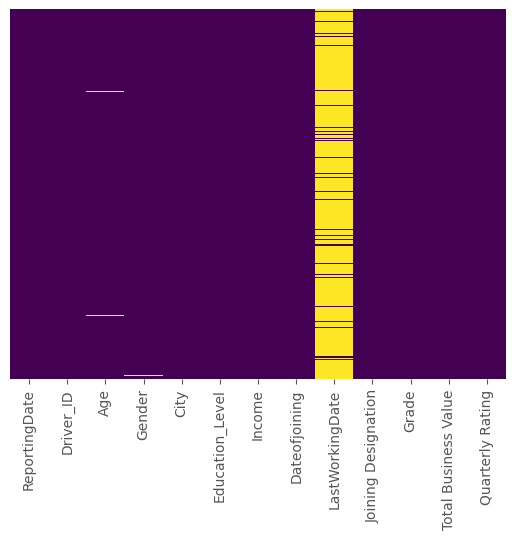

In [8]:
# checking null values with heatmap
sns.heatmap(df.isnull(), cbar=False,yticklabels=False ,cmap="viridis")

**Observation:**

Age and Gender has some missing/null values whereas LastWorkingDate has 91% missing values.

In [ ]:
# checking statistical summary
round(df.describe(),2)
# Output is hidden

**Observations:**

1. There are 19104 driver id but max driver id is 2788 that means it contains duplicate values.
2. Mean age of driver is 34 years whereas min and max age are 21 and 58 years respectively. It may contain fewer outliers.
3. Mean and Median income of a driver are 65k and 60k respectively. Difference in mean and median shows there are outliers present in income.
4. Few features like Gender, Education level, Joining designation,grade and quaterly rating have fewer values and can be converted to a category.
5. Mean and Median value of Total Business value differs alot that may be because its min value is negative. Also there is a very large difference between 75th percentile and max value which shows presence of outliers

In [10]:
# using first/last value as per driver id
create_segment={
    "ReportingDate":"last",
    "Age":"last",
    "Gender":"first",
    "City":"first",
    "Education_Level":"last",
    "Income":["min","max"],
    "Dateofjoining":"first",
    "LastWorkingDate":"last",
    "Joining Designation":"first",
    "Grade":"last",
    "Total Business Value":"sum",
    "Quarterly Rating":["first","last"],
}

In [11]:
# grouping data by driver id 
data=df.groupby(["Driver_ID"]).agg(create_segment).reset_index()
data.columns=["Driver_ID","ReportingDate" ,"Age", "Gender", "City", "Education_Level",
       "Income_min", "Income_max","Dateofjoining", "LastWorkingDate", "Joining Designation",
       "Grade", "Total Business Value", "Quarterly Rating_first","Quarterly Rating_last"]
# creating dependent feature as per last working day
data["Churned"]=data["LastWorkingDate"].isnull()
data["Churned"].replace({True:0,False:1}, inplace=True)
data.head()

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income_min,Income_max,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating_first,Quarterly Rating_last,Churned
0,1,2019-03-01,28.0,0.0,C23,2,57387,57387,24/12/18,03/11/19,1,1,1715580,2,2,1
1,2,2020-12-01,31.0,0.0,C7,2,67016,67016,11/06/20,None,2,2,0,1,1,0
2,4,2020-04-01,43.0,0.0,C13,2,65603,65603,12/07/19,27/04/20,2,2,350000,1,1,1
3,5,2019-03-01,29.0,0.0,C9,0,46368,46368,01/09/19,03/07/19,1,1,120360,1,1,1
4,6,2020-12-01,31.0,1.0,C11,1,78728,78728,31/07/20,None,3,3,1265000,1,2,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Driver_ID               2381 non-null   int64         
 1   ReportingDate           2381 non-null   datetime64[ns]
 2   Age                     2381 non-null   float64       
 3   Gender                  2381 non-null   float64       
 4   City                    2381 non-null   object        
 5   Education_Level         2381 non-null   int64         
 6   Income_min              2381 non-null   int64         
 7   Income_max              2381 non-null   int64         
 8   Dateofjoining           2381 non-null   object        
 9   LastWorkingDate         1616 non-null   object        
 10  Joining Designation     2381 non-null   int64         
 11  Grade                   2381 non-null   int64         
 12  Total Business Value    2381 non-null   int64   

**Observation:**

As we have selected first and last value, null value for gender and age is reduced to 0.

In [13]:
# checking unique values and value counts
def check_value(data,col):
  print("col-",col)
  print("Total Unique Instance:",data[col].nunique())
  print("Unique Values:",data[col].unique())
  print("Value Counts:")
  print(round(data[col].value_counts(normalize=True)[:10]*100,2))
  print("*"*50)

cols=["Gender","City","Education_Level","Joining Designation","Grade","Quarterly Rating_last","Churned"]
for col in cols:
  check_value(data,col)

col- Gender
Total Unique Instance: 2
Unique Values: [0. 1.]
Value Counts:
0.0    58.97
1.0    41.03
Name: Gender, dtype: float64
**************************************************
col- City
Total Unique Instance: 29
Unique Values: ['C23' 'C7' 'C13' 'C9' 'C11' 'C2' 'C19' 'C26' 'C20' 'C17' 'C29' 'C10'
 'C24' 'C14' 'C6' 'C28' 'C5' 'C18' 'C27' 'C15' 'C8' 'C25' 'C21' 'C1' 'C4'
 'C3' 'C16' 'C22' 'C12']
Value Counts:
C20    6.38
C15    4.24
C29    4.03
C26    3.91
C8     3.74
C27    3.74
C10    3.61
C16    3.53
C22    3.44
C3     3.44
Name: City, dtype: float64
**************************************************
col- Education_Level
Total Unique Instance: 3
Unique Values: [2 0 1]
Value Counts:
2    33.68
1    33.39
0    32.93
Name: Education_Level, dtype: float64
**************************************************
col- Joining Designation
Total Unique Instance: 5
Unique Values: [1 2 3 4 5]
Value Counts:
1    43.09
2    34.23
3    20.71
4     1.51
5     0.46
Name: Joining Designation, dtype: flo

**Observations:**

1. Drivers from 29 unique cities are present from C1 to C29. Out of which, max drivers are from city C20, C15 and C29.
2. Majority of Drivers are Male.
3. Equal proportion of drivers are present who have education level of Graduation, 12+ and 10+.
4. Majority of Drivers have joining designation, grade and quaterly rating of 1 and 2.
5. Around 67% of the Drivers left whereas 33% are still working.

## **Univariate Analysis**

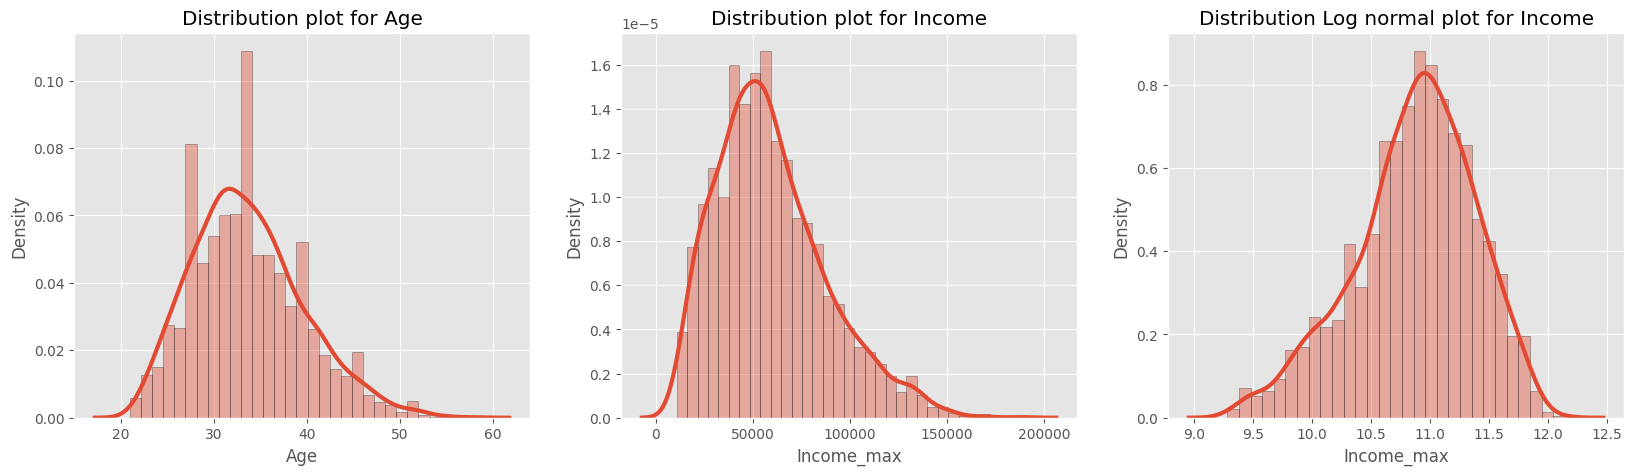

In [14]:
# Distribution plot for Age and Income
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
sns.distplot(data["Age"], hist=True, hist_kws={"edgecolor":"black"}, kde_kws={"linewidth":3})
plt.title("Distribution plot for Age")

plt.subplot(1,3,2)
sns.distplot(data["Income_max"], hist=True, hist_kws={"edgecolor":"black"}, kde_kws={"linewidth":3})
plt.title("Distribution plot for Income")

plt.subplot(1,3,3)
sns.distplot(np.log(data["Income_max"]), hist=True, hist_kws={"edgecolor":"black"}, kde_kws={"linewidth":3})
plt.title("Distribution Log normal plot for Income")
plt.show()

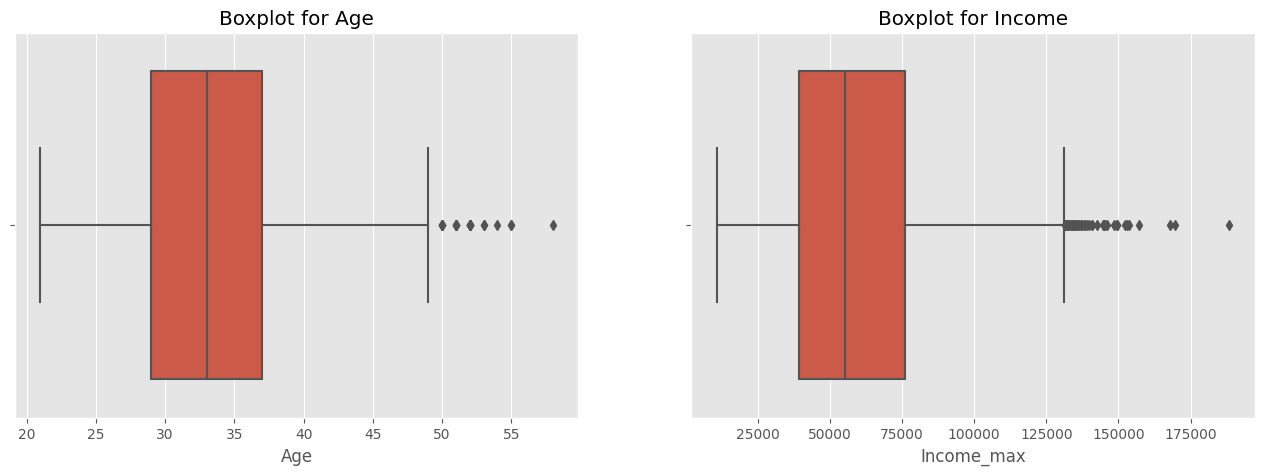

In [15]:
# Boxplot for Age and Income
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.boxplot(x="Age",data=data)
plt.title("Boxplot for Age")

plt.subplot(1,2,2)
sns.boxplot(x="Income_max",data=data)
plt.title("Boxplot for Income")
plt.show()

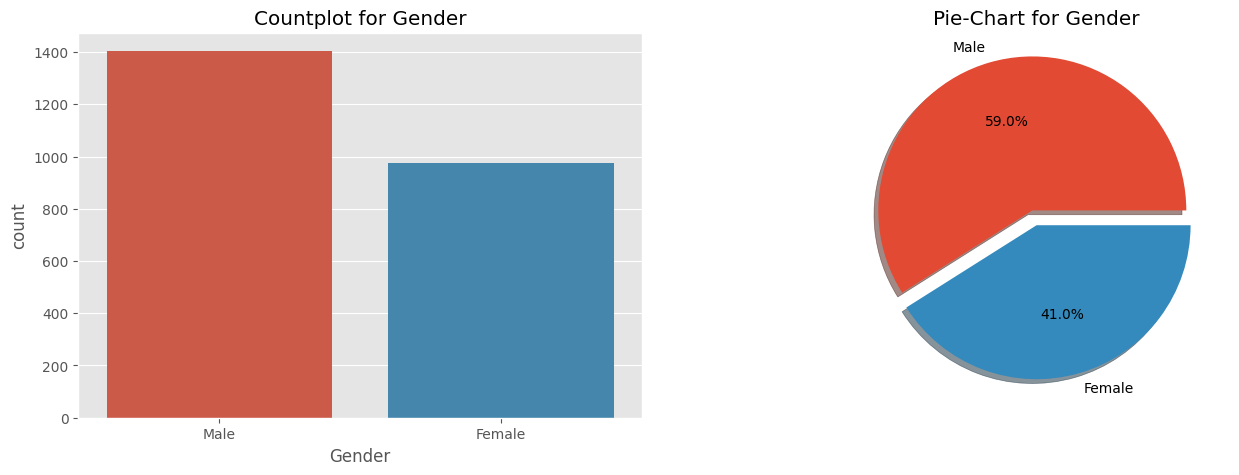

In [16]:
# countplot and pie-chart for Gender
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Gender",data=data)
plt.xticks(ticks=[0,1],labels=["Male","Female"])
plt.title("Countplot for Gender")

plt.subplot(1,2,2)
plt.pie(data["Gender"].value_counts(),
        labels=["Male","Female"], autopct="%0.1f%%", 
        explode=[0.1,0],shadow=True)
plt.title("Pie-Chart for Gender")
plt.show()

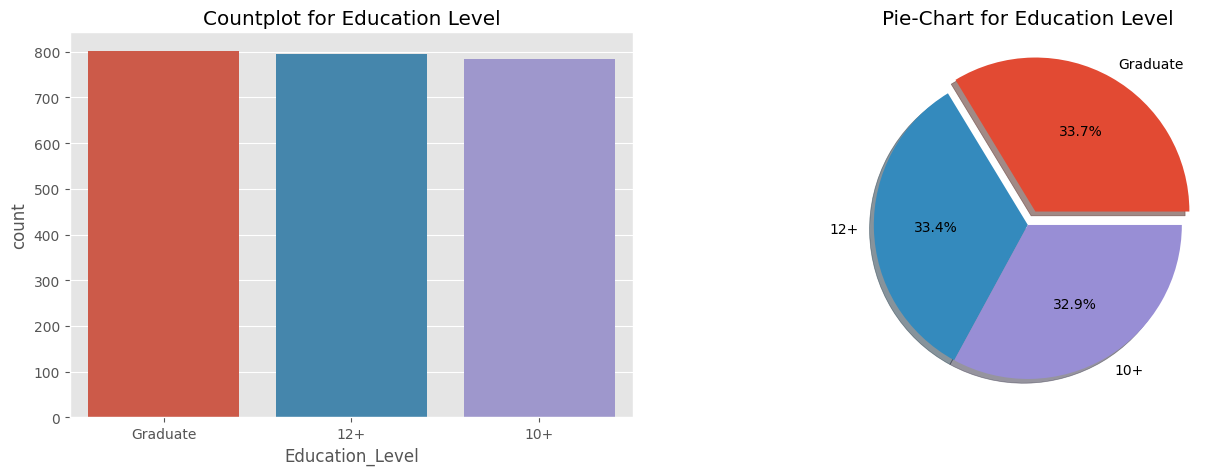

In [17]:
# countplot and pie-chart for Education Level
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Education_Level",data=data,
              order=list(data["Education_Level"].value_counts().index))
plt.xticks(ticks=[0,1,2],labels=["Graduate","12+","10+"])
plt.title("Countplot for Education Level")

plt.subplot(1,2,2)
plt.pie(data["Education_Level"].value_counts(),
        labels=["Graduate","12+","10+"] ,autopct="%0.1f%%", 
        explode=[0.1,0,0],shadow=True)
plt.title("Pie-Chart for Education Level")
plt.show()

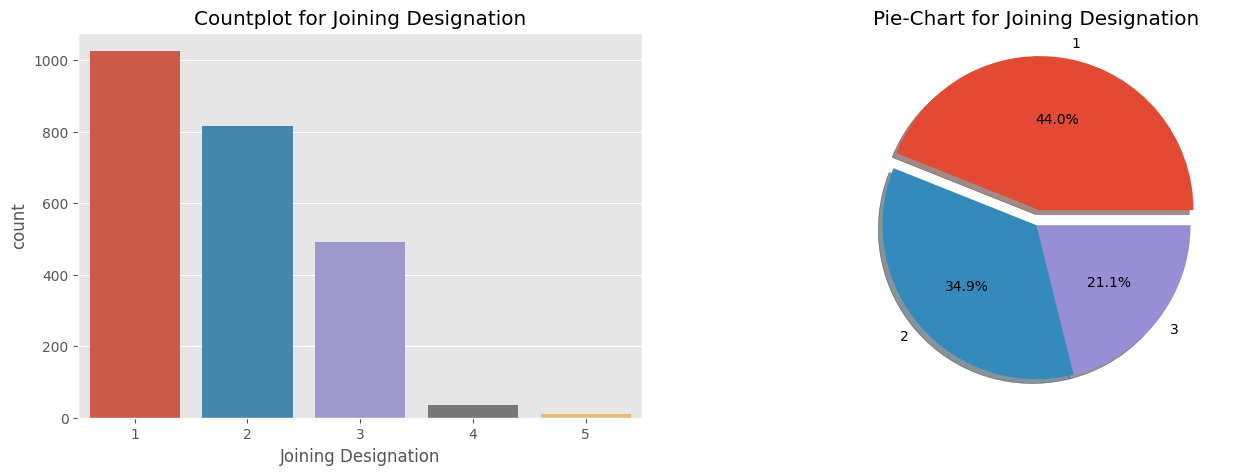

In [18]:
# countplot and pie-chart for Joining Designation
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Joining Designation",data=data,order=list(data["Joining Designation"].value_counts().index))
plt.title("Countplot for Joining Designation")

plt.subplot(1,2,2)
plt.pie(data["Joining Designation"].value_counts()[:3],
        labels=list(data["Joining Designation"].value_counts().index)[:3],
        autopct="%0.1f%%",explode=[0.1,0,0], shadow=True)
plt.title("Pie-Chart for Joining Designation")
plt.show()

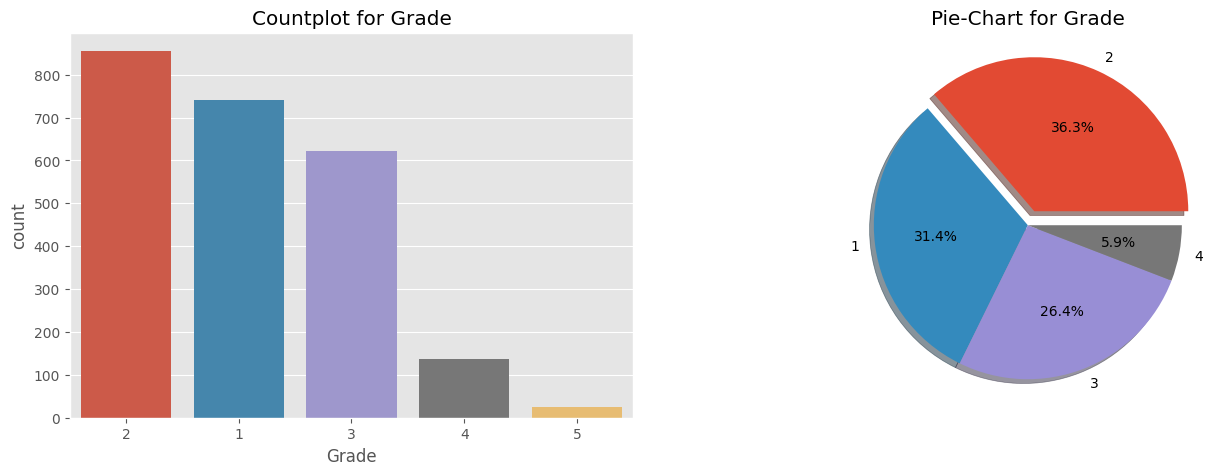

In [19]:
# countplot and pie-chart for Grade
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Grade",data=data,order=list(data["Grade"].value_counts().index))
plt.title("Countplot for Grade")

plt.subplot(1,2,2)
plt.pie(data["Grade"].value_counts()[:4],
        labels=list(data["Grade"].value_counts().index)[:4],
        autopct="%0.1f%%",explode=[0.1,0,0,0], shadow=True)
plt.title("Pie-Chart for Grade")
plt.show()

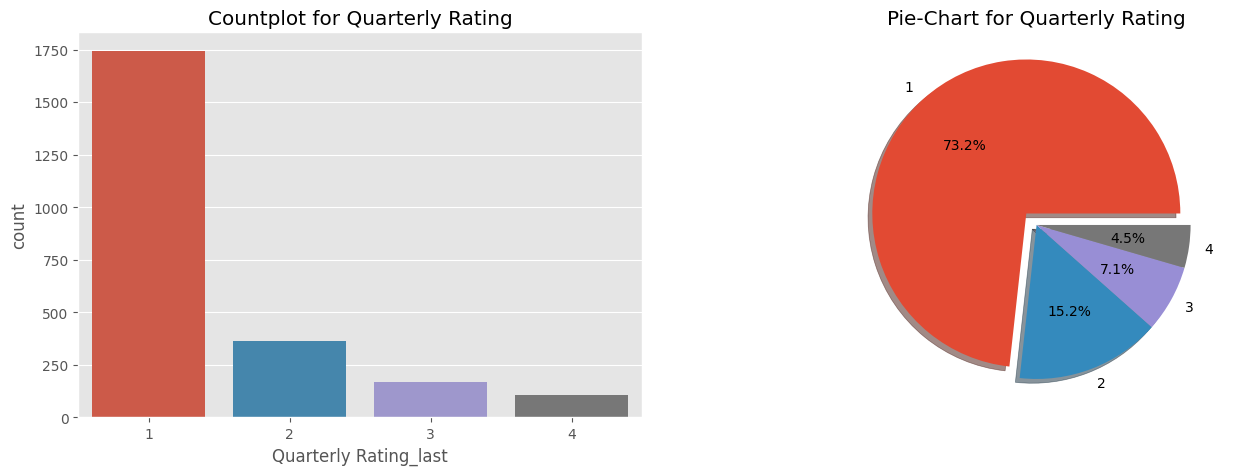

In [20]:
# countplot and pie-chart for Quarterly Rating
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Quarterly Rating_last",data=data,order=list(data["Quarterly Rating_last"].value_counts().index))
plt.title("Countplot for Quarterly Rating")

plt.subplot(1,2,2)
plt.pie(data["Quarterly Rating_last"].value_counts(),
        labels=list(data["Quarterly Rating_last"].value_counts().index),
        autopct="%0.1f%%",explode=[0.1,0,0,0] , shadow=True)
plt.title("Pie-Chart for Quarterly Rating")
plt.show()

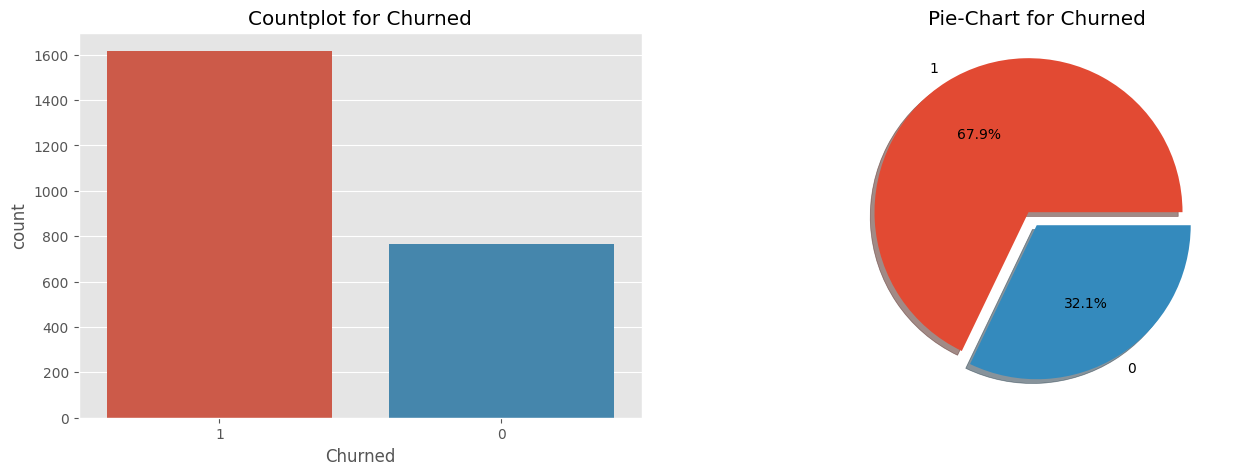

In [21]:
# countplot and pie-chart for Churned
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Churned",data=data,order=list(data["Churned"].value_counts().index))
plt.title("Countplot for Churned")

plt.subplot(1,2,2)
plt.pie(data["Churned"].value_counts(),
        labels=list(data["Churned"].value_counts().index),
        autopct="%0.1f%%",explode=[0.1,0], shadow=True)
plt.title("Pie-Chart for Churned")
plt.show()

**Observations:**

1. Distribution of Age looks like right skewed normal distribution where majority of drivers are from the age group of 30-40.
2. Distribution of Income looks like log normal distribution where majority of drivers have income around 50k-60k and very few drivers have income above 150k.
3. Drivers of age range 20-60 are present but age above 50 are outliers.
4. There are many outliers in income above ~130k.
5. 59% of the drivers are male whereas 41% are female.
6. 44% of the drivers have joining designation of 1 followed by 35% and 21% drivers with joining designation of 2 and 3 respectively.
7. 36% of the drivers have grade of 2 followed by 31% and 26% drivers with joining designation of 1 and 3 respectively.
8. 73% of the drivers have quaterly rating of 1 followed by 15% of rating 2.
9. 68% of the drivers churned whereas 32% are still working in organization.

## **Bivariate Analysis**

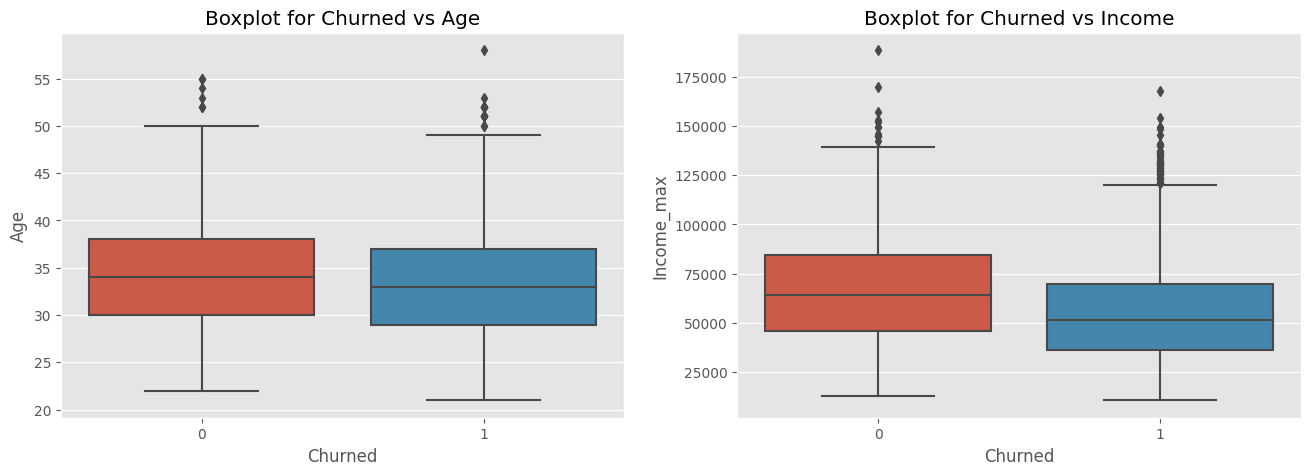

In [22]:
# Boxplot for Churned v/s age and Income
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.boxplot(x="Churned",y="Age",data=data)
plt.title("Boxplot for Churned vs Age")

plt.subplot(1,2,2)
sns.boxplot(x="Churned",y="Income_max",data=data)
plt.title("Boxplot for Churned vs Income")
plt.show()

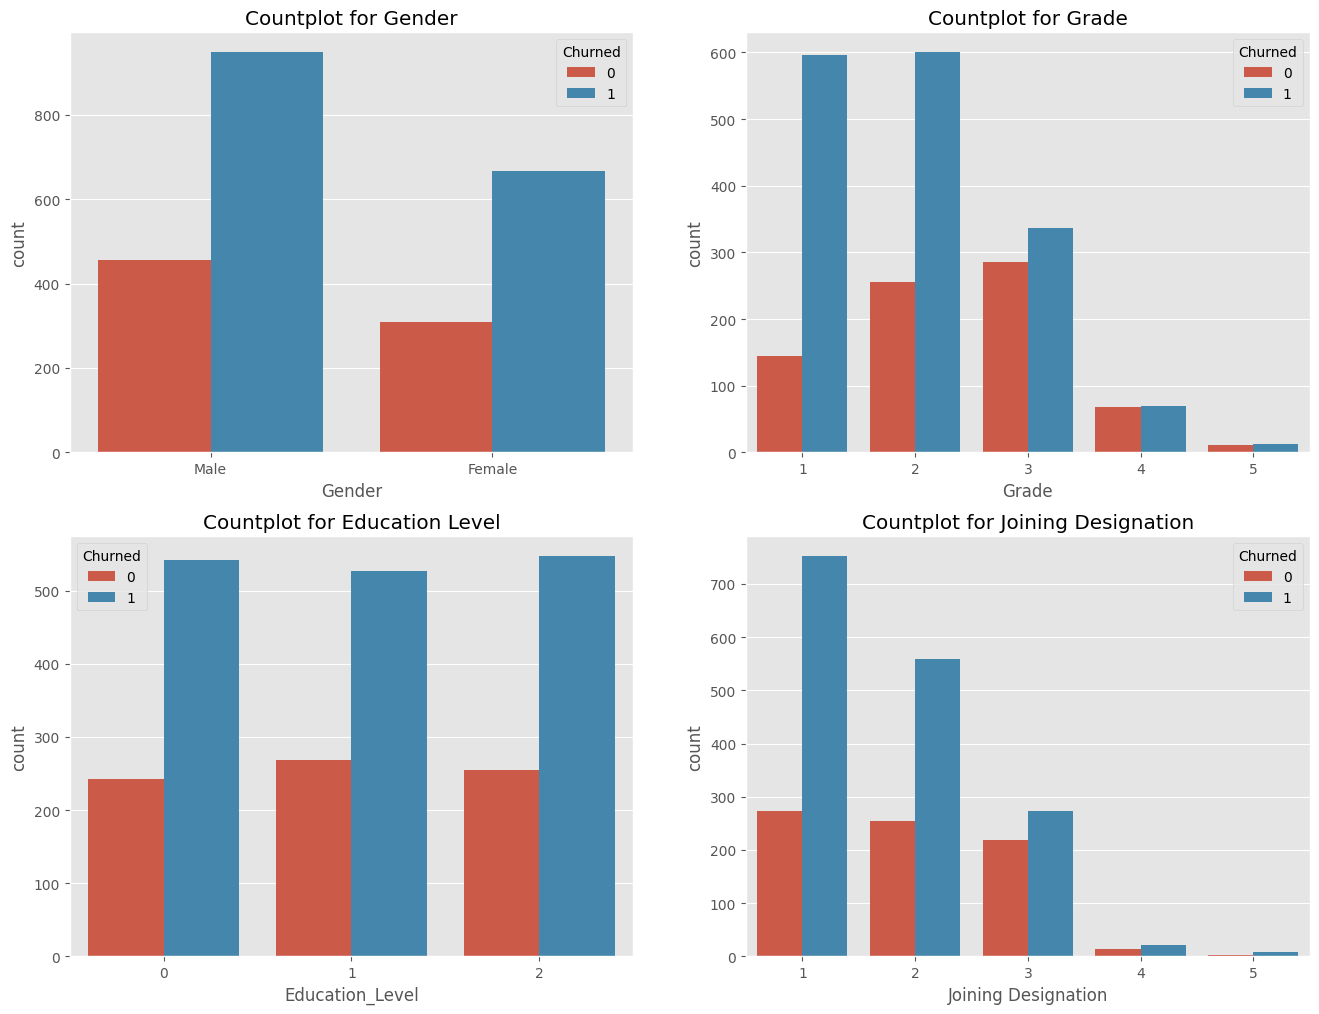

In [23]:
# countplot for Churned v/s Gender and Grade
plt.figure(figsize=(16,12))
plt.subplot(2,2,1)
sns.countplot(x="Gender",data=data,hue="Churned")
plt.xticks(ticks=[0,1],labels=["Male","Female"])
plt.title("Countplot for Gender")

plt.subplot(2,2,2)
sns.countplot(x="Grade",data=data,hue="Churned")
plt.title("Countplot for Grade")

plt.subplot(2,2,3)
sns.countplot(x="Education_Level",data=data,hue="Churned")
plt.title("Countplot for Education Level")

plt.subplot(2,2,4)
sns.countplot(x="Joining Designation",data=data,hue="Churned")
plt.title("Countplot for Joining Designation")
plt.show()

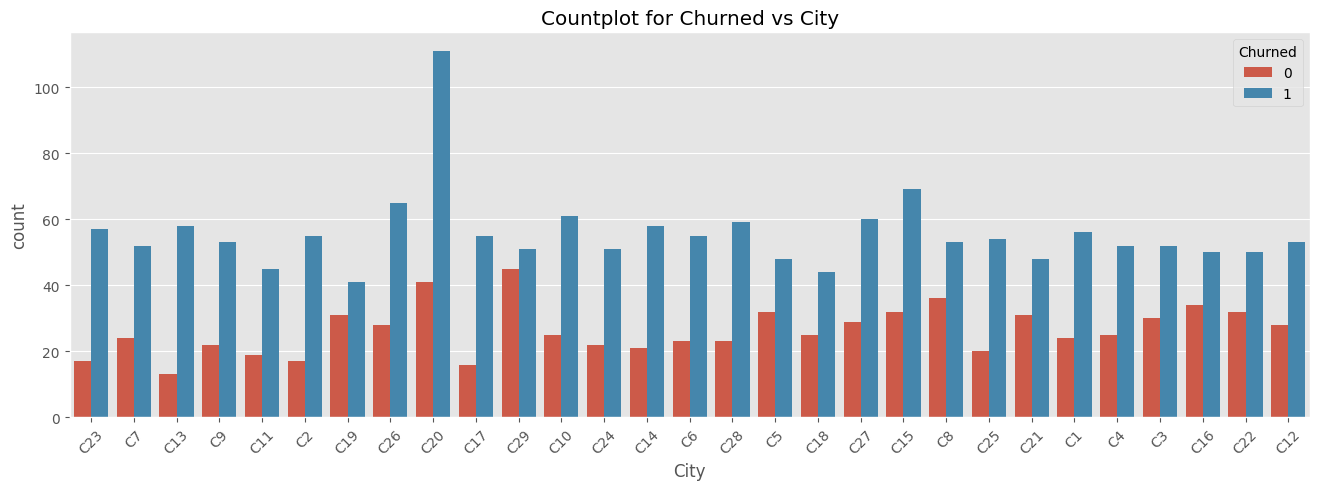

In [24]:
# countplot for Churned v/s City
plt.figure(figsize=(16,5))
sns.countplot(x="City",data=data,hue="Churned")
plt.xticks(rotation=45)
plt.title("Countplot for Churned vs City")
plt.show()

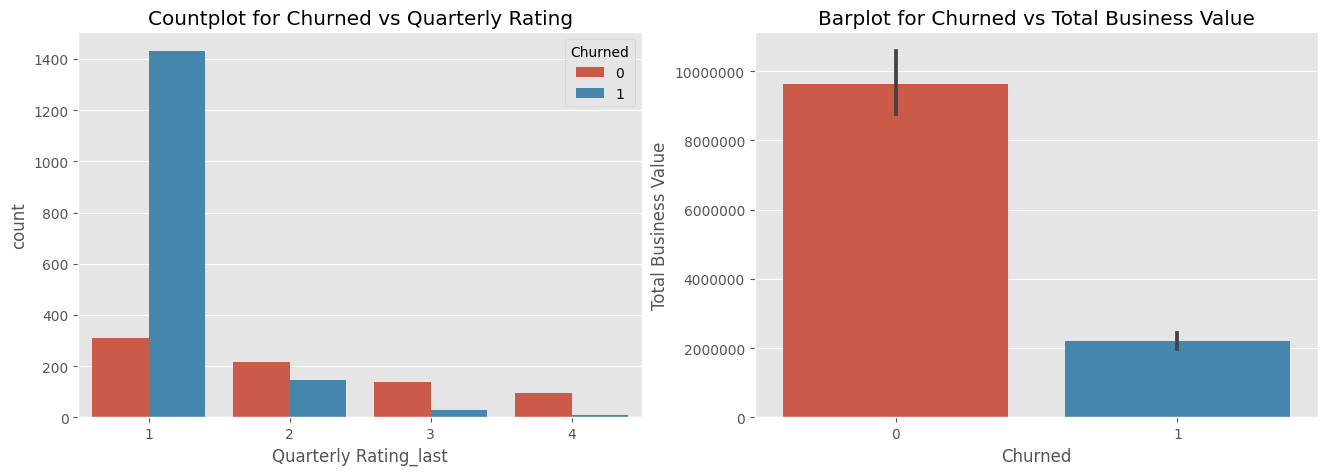

In [25]:
# countplot for Churned v/s Quarterly Rating
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.countplot(x="Quarterly Rating_last",data=data,hue="Churned")
plt.title("Countplot for Churned vs Quarterly Rating")

plt.subplot(1,2,2)
sns.barplot(x="Churned",y="Total Business Value",data=data)
plt.ticklabel_format(style='plain', axis='y')
plt.title("Barplot for Churned vs Total Business Value")
plt.show()

**Observations:**

1. Median of Age of drivers who didnt churned is slightly higher than churned drivers. Also there are more outliers in age of drivers who churned.
2. Median of Income of drivers who didnt churned is higher than churned drivers. ( # insight->that may be one of the reason of churning) There are few outliers who have high income but still they are churning which can be analyzed further.
3. There are more male drivers who are churning compared to females.
4. Drivers of grade 3,4, and 5 have equal rate of churning and non-churning whereas drivers with rating of 1 and 2 are churning more.
5. Proportion of churning is almost same of all education level.
6. Drivers of joining designation 1 and 2 have higher proportion of churning compared to joining designation of 3,4 and 5.
7. More drivers are churned from the city C20 but its explainatory as the no of drivers is higher in C20 compared to other cities. Proportion of churning and non churning is looking same for all other cities.
8. Majority of the drivers who churned have a quaterly rating of 1.
9. Drivers who have churned have very low mean business value compared to drivers who stayed.

## **Multivariate Analysis**

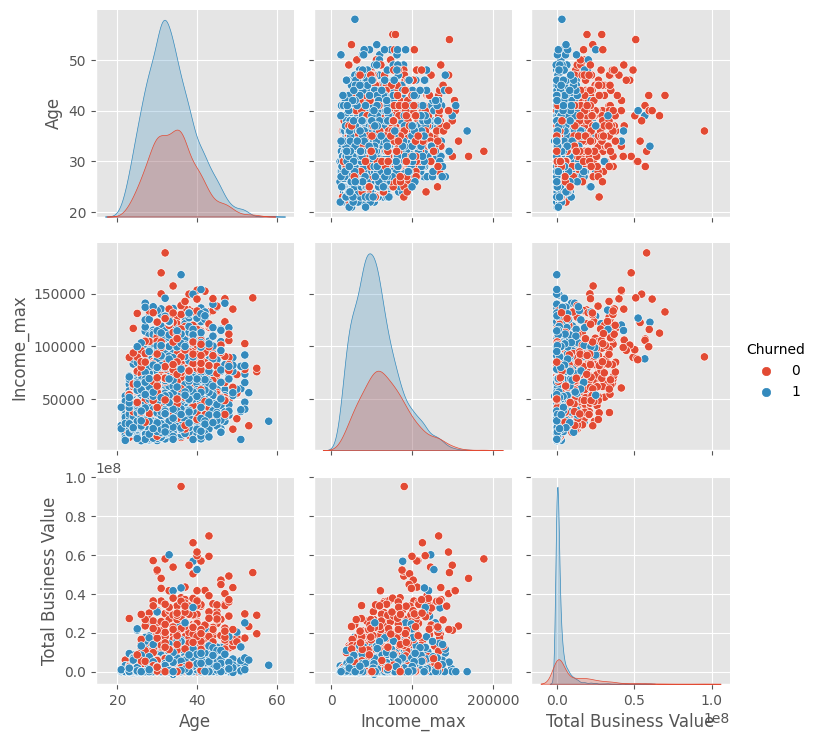

In [26]:
# pairplot for continuous features
cols=["Age","Income_max","Total Business Value","Churned"]
data2=data[cols]
sns.pairplot(data2, hue="Churned")

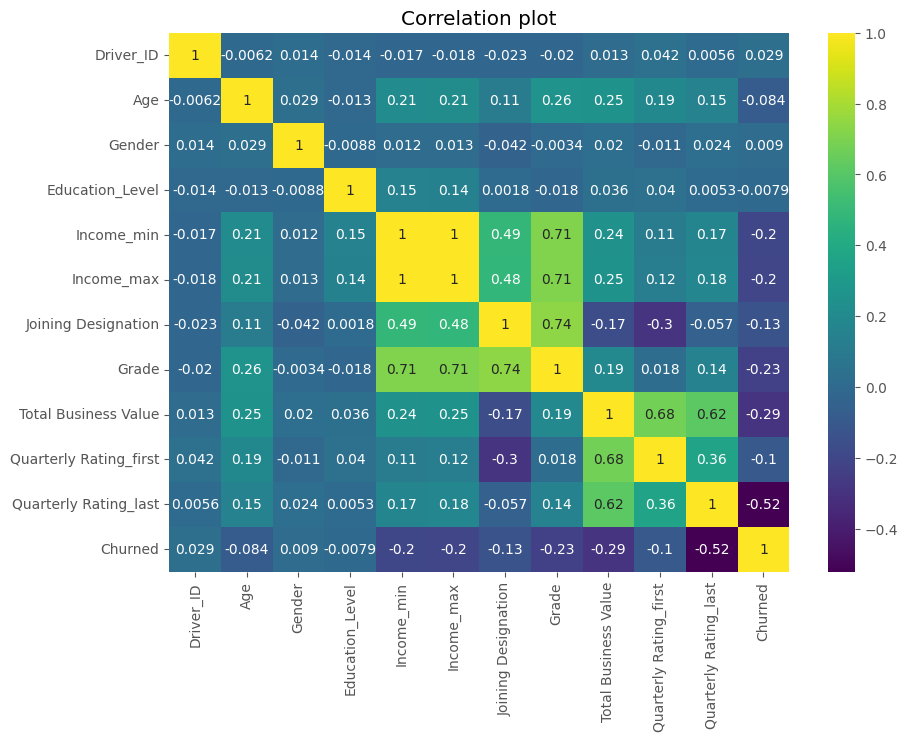

In [27]:
# Correlation plot
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(method="spearman"),annot=True,cmap="viridis")
plt.title("Correlation plot")
plt.show()

**Observations:**

1. Churned and Quarterly rating are negative correlated which we have also observed the max drivers who churned have lower quaterly rating.
2. Churned and total business value are negative correlated that is also observed, drivers with lower business value are churning.
3. There is a negative correlation between drivers churning and income, grade and joining designation.
4. Grade is correlated with total business value, quaterly rating and age. 
5. Quaterly rating has a positive correlation with age and total business Value.
6. Income has a positive correlation with Education level.
7. Age has a positive correlation with Income, Joining Designation, grade, total business value and quarterly rating.
8. Income is positively correlated with joining designation, grade, total business value and quarterly rating.

## **Data Preprocessing**

### **Duplicate Detection**

In [28]:
np.any(data.duplicated())

False

In [29]:
data[data.duplicated()]

,Driver_ID,ReportingDate,Age,Gender,City,Education_Level,Income_min,Income_max,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating_first,Quarterly Rating_last,Churned


**Observation:**

There are no duplicate values in dataset.

### **Missing Value Treatment**

In [30]:
# filling last working day null values with ReportingDate to fetch the years of service later
data["LastWorkingDate"].fillna(data["ReportingDate"], inplace=True)

In [31]:
data.isnull().sum()

Driver_ID                 0
ReportingDate             0
Age                       0
Gender                    0
City                      0
Education_Level           0
Income_min                0
Income_max                0
Dateofjoining             0
LastWorkingDate           0
Joining Designation       0
Grade                     0
Total Business Value      0
Quarterly Rating_first    0
Quarterly Rating_last     0
Churned                   0
dtype: int64

**Observation:**

There are no missing values in dataset.

### **Outlier Detection and Treatment**

In [32]:
# detecting outliers for age, income and total business value
continuous_cols=["Age","Income_max","Total Business Value"]

def check_outliers(data,col):
  quantiles=np.percentile(data[col],np.arange(0,100,25))
  IQR=round((quantiles[3]-quantiles[1]),2)
  min_value=round((quantiles[1] - (1.5*IQR)) ,2)
  max_value=round((quantiles[3] + (1.5*IQR)) ,2)
  print("Inter-Quartile Range for "+str(col)+":",IQR)
  print("Min value for "+str(col)+":",min_value)
  print("Max value for "+str(col)+":",max_value)
  print("*"*50)

for col in continuous_cols:
  check_outliers(data,col)

Inter-Quartile Range for Age: 8.0
Min value for Age: 17.0
Max value for Age: 49.0
**************************************************
Inter-Quartile Range for Income_max: 36882.0
Min value for Income_max: -16219.0
Max value for Income_max: 131309.0
**************************************************
Inter-Quartile Range for Total Business Value: 4173650.0
Min value for Total Business Value: -6260475.0
Max value for Total Business Value: 10434125.0
**************************************************


In [33]:
# checking percentage of outliers for Age, Income and Total Business Value
print("Percentage of outliers for Age:"+str(round(len(data[(data["Age"]<17) | (data["Age"]>49)])/len(data),3))+"%")
print("Percentage of outliers for Income:"+str(round(len(data[data["Income_max"]>131309])/len(data),3))+"%")
print("Percentage of outliers for Total Business Value:"+str(round(len(data[data["Total Business Value"]>10434125])/len(data),3))+"%")

Percentage of outliers for Age:0.01%
Percentage of outliers for Income:0.02%
Percentage of outliers for Total Business Value:0.141%


Outliers is not removed as data points are less.

### **Feature Engineering**

In [34]:
# converting date feature into date format
data["Dateofjoining"]=pd.to_datetime(data["Dateofjoining"])
data["LastWorkingDate"]=pd.to_datetime(data["LastWorkingDate"])

In [35]:
# getting years of service
data["YearsOfService"]=round((data["LastWorkingDate"]-data["Dateofjoining"])/np.timedelta64(1,"Y"),2)
# dropping LastWorkingDate
data.drop("LastWorkingDate", axis=1, inplace=True)
# Assigning value=1 for increased quaterly rating
data["IncresedQuarterlyRating"]=data["Quarterly Rating_last"]-data["Quarterly Rating_first"]
data["IncresedQuarterlyRating"]=data["IncresedQuarterlyRating"].apply(lambda x: 1 if int(x)>0 else 0)
# dropping first Quarterly rating and renaming last Quarterly rating
data.drop(["Quarterly Rating_first"], axis=1,inplace=True)
data.rename({"Quarterly Rating_last":"Quarterly Rating"},axis=1,inplace=True)
# Assigning value=1 for increased income
data["IncresedMonthlyIncome"]=data["Income_max"]-data["Income_min"]
data["IncresedMonthlyIncome"]=data["IncresedMonthlyIncome"].apply(lambda x: 1 if int(x)>0 else 0)
# dropping first Income and renaming last income 
data.drop(["Income_min"], axis=1,inplace=True)
data.rename({"Income_max":"Income"},axis=1,inplace=True)

In [36]:
# dropping columns which are not required
data.drop(["Driver_ID","ReportingDate","Dateofjoining"], axis=1,inplace=True)

In [37]:
data.describe()

,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating,Churned,YearsOfService,IncresedQuarterlyRating,IncresedMonthlyIncome
count,2381.000000,2381.000000,2381.00000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000
mean,33.663167,0.410332,1.00756,59336.159597,1.820244,2.096598,4.586742e+06,1.427971,0.678706,1.162323,0.150357,0.018480
std,5.983375,0.491997,0.81629,28383.012146,0.841433,0.941522,9.127115e+06,0.809839,0.467071,1.545234,0.357496,0.134706
min,21.000000,0.000000,0.00000,10747.000000,1.000000,1.000000,-1.385530e+06,1.000000,0.000000,-0.070000,0.000000,0.000000
25%,29.000000,0.000000,0.00000,39104.000000,1.000000,1.000000,0.000000e+00,1.000000,0.000000,0.250000,0.000000,0.000000
50%,33.000000,0.000000,1.00000,55315.000000,2.000000,2.000000,8.176800e+05,1.000000,1.000000,0.490000,0.000000,0.000000
75%,37.000000,1.000000,2.00000,75986.000000,2.000000,3.000000,4.173650e+06,2.000000,1.000000,1.280000,0.000000,0.000000
max,58.000000,1.000000,2.00000,188418.000000,5.000000,5.000000,9.533106e+07,4.000000,1.000000,7.670000,1.000000,1.000000


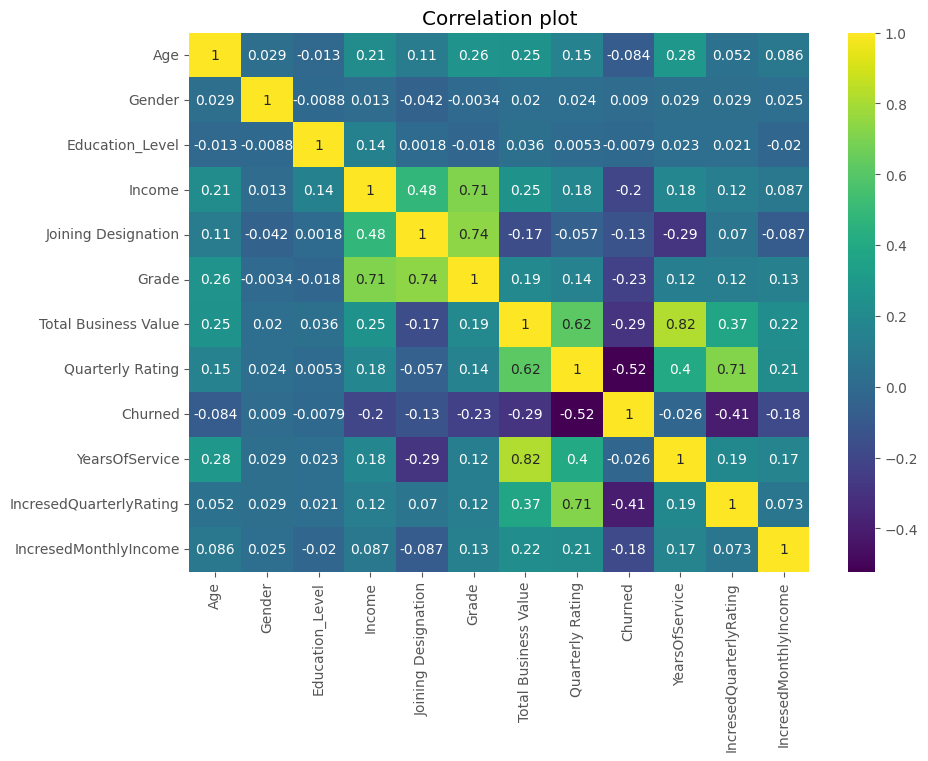

In [38]:
# Correlation plot
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(method="spearman"),annot=True,cmap="viridis")
plt.title("Correlation plot")
plt.show()

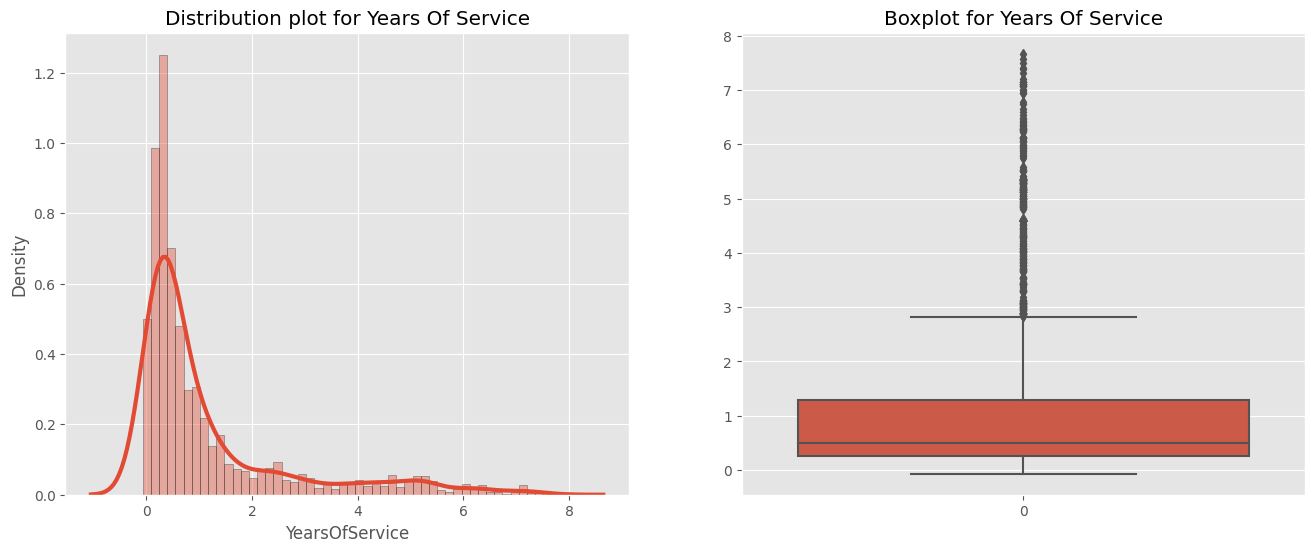

In [39]:
# Distribution and boxplot for years of service
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.distplot(data["YearsOfService"], hist=True, hist_kws={"edgecolor":"black"}, kde_kws={"linewidth":3})
plt.title("Distribution plot for Years Of Service")

plt.subplot(1,2,2)
sns.boxplot(data["YearsOfService"])
plt.title("Boxplot for Years Of Service")
plt.show()

In [40]:
# putting YearsOfService to 0 who joined in the same month of reporting
data.loc[data["YearsOfService"]<0,"YearsOfService"]=0

In [41]:
# encoding City using TargetEncoding
encoding=TargetEncoder()
data["City"]=encoding.fit_transform(data["City"],data["Churned"])

### **Data Preparation**

In [42]:
# separating dependent and independent variables
X=data.drop(["Churned"],axis=1)
y=data["Churned"]

In [43]:
# train test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

### **Handling Imbalance Data**

In [44]:
# using SMOTE to balance data
sm=SMOTE()
X_sm,y_sm=sm.fit_resample(X_train,y_train)

In [45]:
# performing feature scaling
scaler=StandardScaler()
col=["Age","City","Income","Total Business Value"]
scaler.fit(X_train[col])

X_train[col]=scaler.transform(X_train[col])
X_test[col]=scaler.transform(X_test[col])

## **Model Training**

### **Decision Trees**

In [ ]:
# Declaring params for grid search cv
params={
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2,3,4,5,8,10],
    "min_samples_split": [2,3,4,5,8,10],
    "ccp_alpha":[0.0001,0.001,0.005,0.01],
    "min_samples_leaf": [2,3,4,5,8,10],
}

In [ ]:
# training decision tree model
tree_model=DecisionTreeClassifier()
grid_model=GridSearchCV(estimator=tree_model,param_grid=params, scoring="accuracy", verbose=1, n_jobs=-1, return_train_score=True,)
grid_model.fit(X_sm,y_sm)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


GridSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.005, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 8, 10],
                         'min_samples_leaf': [2, 3, 4, 5, 8, 10],
                         'min_samples_split': [2, 3, 4, 5, 8, 10]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
grid_model.best_params_

{'ccp_alpha': 0.005,
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [ ]:
# best score for decision tree
grid_model.best_score_

0.8312879570412373

In [ ]:
# training decision tree with best params
best_model=DecisionTreeClassifier(**grid_model.best_params_)
best_model.fit(X_sm,y_sm)

DecisionTreeClassifier(ccp_alpha=0.005, criterion='entropy', max_depth=10,
                       min_samples_leaf=2)

In [ ]:
# feature importance for decision tree
Feat_Imp_DT=pd.DataFrame(np.round(best_model.feature_importances_,3),index=X_train.columns,
                      columns=["Importance"]).reset_index().sort_values(by="Importance",ascending=False)
Feat_Imp_DT.rename({"index":"Features"}, axis=1, inplace=True)
Feat_Imp_DT

,Features,Importance
8,Quarterly Rating,0.386
9,YearsOfService,0.322
7,Total Business Value,0.189
5,Joining Designation,0.038
2,City,0.033
1,Gender,0.032
0,Age,0.000
3,Education_Level,0.000
4,Income,0.000
6,Grade,0.000


### **Random Forest**

In [ ]:
# Declaring params for grid search cv
params={
    "n_estimators" :[100,200,300],
    "criterion" : ["gini","entropy"],
    "max_depth" : [3,4,5,8],
    "min_samples_split": [2,3,4],
    "ccp_alpha":[0.0001,0.001],
    "min_samples_leaf": [2,3,4],
}

In [ ]:
# training random forest model using random search cv
rf_model=RandomForestClassifier()
grid_model=GridSearchCV(estimator=rf_model, param_grid=params, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
grid_model.fit(X_sm,y_sm)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0001, 0.001], 'criterion': ['gini'],
                         'max_depth': [3, 4, 5, 8],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
grid_model.best_params_

{'ccp_alpha': 0.0001,
 'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 200}

In [ ]:
# best score for random forest
grid_model.best_score_

0.8469806524398731

In [ ]:
# training random forest with best params
best_model=RandomForestClassifier(**grid_model.best_params_)
best_model.fit(X_sm,y_sm)

RandomForestClassifier(ccp_alpha=0.0001, max_depth=8, min_samples_leaf=4,
                       min_samples_split=3, n_estimators=200)

In [ ]:
# feature importance for random forest
Feat_Imp_RF=pd.DataFrame(np.round(best_model.feature_importances_,3),index=X_train.columns,
                      columns=["Importance"]).reset_index().sort_values(by="Importance",ascending=False)
Feat_Imp_RF.rename({"index":"Features"}, axis=1, inplace=True)
Feat_Imp_RF

,Features,Importance
8,Quarterly Rating,0.256
9,YearsOfService,0.221
7,Total Business Value,0.186
10,IncresedQuarterlyRating,0.068
2,City,0.061
4,Income,0.060
1,Gender,0.046
0,Age,0.044
5,Joining Designation,0.023
3,Education_Level,0.017


### **Gradient Boosting Decision Tree**

In [ ]:
# Declaring params for grid search cv
params={
    "n_estimators" :[100,200,300,400],
    "learning_rate": [0.1,0.2,0.3,0.4],
    "max_depth" : [2,3,4,5],
    "min_samples_split": [2,3,4,5],
    "ccp_alpha":[0.0001,0.001,0.005],
    "max_leaf_nodes": [2,3,4,5],
    "subsample": [0.7,0.8,0.9,1]
}

In [ ]:
# training gradient boosting model
gbdt_model=GradientBoostingClassifier()
random_model=RandomizedSearchCV(estimator=gbdt_model, param_distributions=params, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
random_model.fit(X_sm,y_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0001, 0.001, 0.005],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_leaf_nodes': [2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400],
                                        'subsample': [0.7, 0.8, 0.9, 1]},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
random_model.best_params_

{'subsample': 0.9,
 'n_estimators': 100,
 'min_samples_split': 3,
 'max_leaf_nodes': 4,
 'max_depth': 3,
 'learning_rate': 0.4,
 'ccp_alpha': 0.0001}

In [ ]:
# best score for gradient boosting
random_model.best_score_

0.8691662454305034

In [ ]:
# training gbdt with best params
best_model=GradientBoostingClassifier(**random_model.best_params_)
best_model.fit(X_sm,y_sm)

GradientBoostingClassifier(ccp_alpha=0.0001, learning_rate=0.4,
                           max_leaf_nodes=4, min_samples_split=3,
                           subsample=0.9)

In [ ]:
# feature importance for gbdt
Feat_Imp_GBDT=pd.DataFrame(np.round(best_model.feature_importances_,3),index=X_train.columns,
                      columns=["Importance"]).reset_index().sort_values(by="Importance",ascending=False)
Feat_Imp_GBDT.rename({"index":"Features"}, axis=1, inplace=True)
Feat_Imp_GBDT

,Features,Importance
8,Quarterly Rating,0.322
9,YearsOfService,0.274
7,Total Business Value,0.174
1,Gender,0.071
2,City,0.052
0,Age,0.039
4,Income,0.031
5,Joining Designation,0.018
3,Education_Level,0.007
10,IncresedQuarterlyRating,0.006


### **XGBoost**

In [ ]:
# Declaring params for grid search cv
params={
    "n_estimators" :[180,200,220],
    "learning_rate": [0.01,0.1,1],
    "max_depth" : [7,8,9],
    "colsample_bytree": [0.16,0.20,0.25],
    "subsample": [0.15,0.20,0.25],
    "gamma":[0,0.43,0.5],
    "reg_alpha":[0.42,0.5,0.8],
    "reg_lambda":[0.48,0.9,1]
}

In [ ]:
# training xgboost model with gridsearchcv
xgb_model=XGBClassifier()
grid_model=GridSearchCV(estimator=xgb_model, param_grid=params, scoring="accuracy", n_jobs=-1, verbose=1, return_train_score=True)
grid_model.fit(X_sm,y_sm)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.16], 'gamma': [0, 0.43],
                         'learning_rate': [0.01, 0.1], 'max_depth': [7, 8],
                         'n_estimators': [180, 200], 'reg_alpha': [0.42, 0.5],
                         'reg_lambda': [0.48, 0.9], 'subsample': [0.15]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
grid_model.best_params_

{'colsample_bytree': 0.16,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 200,
 'reg_alpha': 0.5,
 'reg_lambda': 0.48,
 'subsample': 0.15}

In [ ]:
# training xgboost with best params
best_model=XGBClassifier(**grid_model.best_params_)
best_model.fit(X_sm,y_sm)

XGBClassifier(colsample_bytree=0.2, gamma=0.43, max_depth=8, n_estimators=180,
              reg_alpha=0.42, reg_lambda=0.48, subsample=0.25)

In [ ]:
best_model.score(X_sm, y_sm)

0.8848508033664881

In [ ]:
# predicting y using best model
y_pred=best_model.predict(X_test)

In [ ]:
# feature importance for gbdt
Feat_Imp_XGB=pd.DataFrame(np.round(best_model.feature_importances_,3),index=X_train.columns,
                      columns=["Importance"]).reset_index().sort_values(by="Importance",ascending=False)
Feat_Imp_XGB.rename({"index":"Features"}, axis=1, inplace=True)
Feat_Imp_XGB

,Features,Importance
8,Quarterly Rating,0.366
10,IncresedQuarterlyRating,0.166
1,Gender,0.133
3,Education_Level,0.053
9,YearsOfService,0.047
0,Age,0.046
7,Total Business Value,0.040
2,City,0.037
6,Grade,0.037
4,Income,0.030


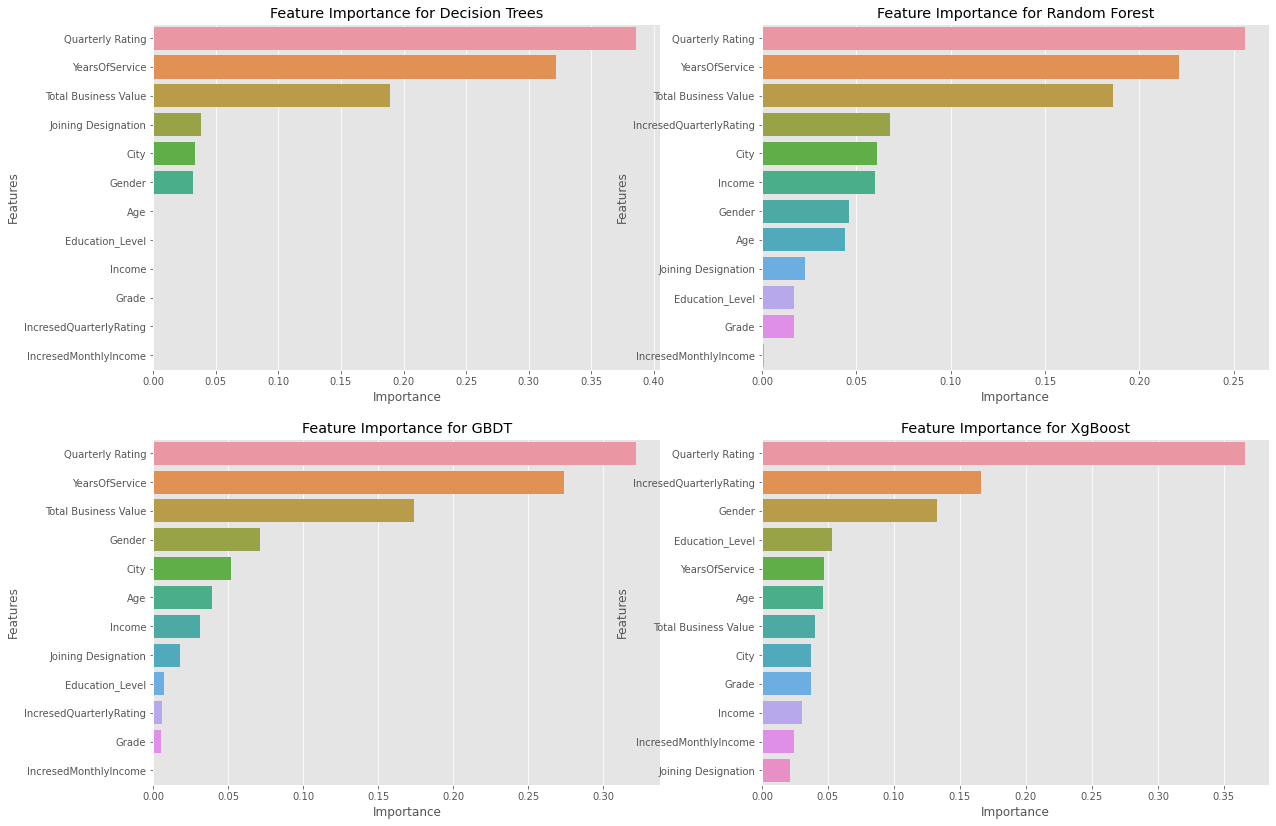

In [ ]:
# plotting feature importance all trained models
plt.figure(figsize=(20,14))

plt.subplot(2,2,1)
sns.barplot(x="Importance",y="Features",data=Feat_Imp_DT)
plt.title("Feature Importance for Decision Trees")

plt.subplot(2,2,2)
sns.barplot(x="Importance",y="Features",data=Feat_Imp_RF)
plt.title("Feature Importance for Random Forest")

plt.subplot(2,2,3)
sns.barplot(x="Importance",y="Features",data=Feat_Imp_GBDT)
plt.title("Feature Importance for GBDT")

plt.subplot(2,2,4)
sns.barplot(x="Importance",y="Features",data=Feat_Imp_XGB)
# plt.xticks(rotation=45)
plt.title("Feature Importance for XgBoost")
plt.show()

## **Model Evaluation**

In [ ]:
# accuracy, precision and recall score
print("Accuracy Score is ",round(accuracy_score(y_test,y_pred),2))
print("Precision Score is ",round(precision_score(y_test,y_pred),2))
print("Recall Score is ",round(recall_score(y_test,y_pred),2))

Accuracy Score is  0.81
Precision Score is  0.81
Recall Score is  0.92


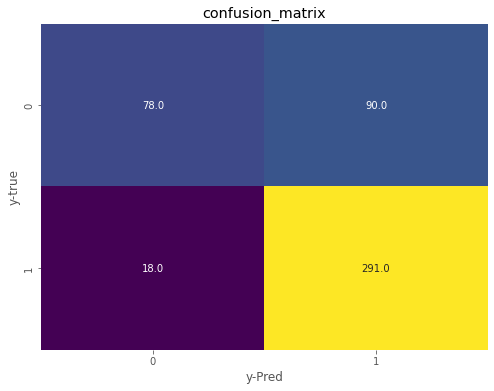

In [ ]:
# plotting confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test,y_pred), cbar=False, annot=True,fmt=".1f" ,cmap="viridis")
plt.xlabel("y-Pred")
plt.ylabel("y-true")
plt.title("confusion_matrix")
plt.show()

**Observation:**

1. Precision score is 0.76 that means False positive is not that high.
Recall score is 0.95 which is also good that means False Negative is less.
2. False positive is 91, whereas False Negative is 15. FP is higher than FN, we can give a bit more importance to FP to balance it.

In [ ]:
# classification report
target_names=["class 0", "class 1"]
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.81      0.46      0.59       168
     class 1       0.76      0.94      0.84       309

    accuracy                           0.77       477
   macro avg       0.79      0.70      0.72       477
weighted avg       0.78      0.77      0.75       477



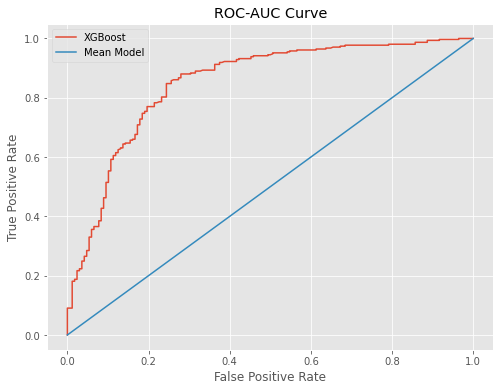

In [ ]:
# plotting roc auc curve
y_scores=pd.DataFrame(best_model.predict_proba(X_test))[1]
fpr, tpr, thresholds=roc_curve(y_test,y_scores)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="XGBoost")
plt.plot([0,1],[0,1],label="Mean Model")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.show()

In [ ]:
# roc auc score
print("ROC-AUC Score is ",round(roc_auc_score(y_test,y_scores),2))

ROC-AUC Score is  0.85


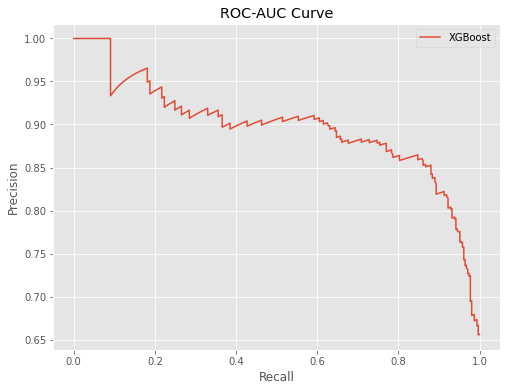

In [ ]:
#plotting precision recall score
y_scores=pd.DataFrame(best_model.predict_proba(X_test))[1]
precision,recall,thresholds=precision_recall_curve(y_test,y_scores)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="XGBoost")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("ROC-AUC Curve")
plt.show()

In [ ]:
# precision recall score
print("Precision Recall Score is ",round(auc(recall,precision),2))

Precision Recall Score is  0.9


In [ ]:
# f1_score
print("F1 Score is ",round(f1_score(y_test,y_pred),2))

F1 Score is  0.86


## **Insights:**

1. 68% of the drivers have churned whereas 32% are still working in organization.
2. Churned drivers have a high negative correlation with Quaterly rating  and total business value and we have also observed that Quaterly rating and total business value has highest feature importance.
3. Male drivers are churning more compared to female drivers.
4. Drivers with a grade of 1 and 2 are churning more compared to other grade drivers.
5. Median Income of drivers who didnt churned is higher than churned drivers.
6. Below are the features which are significant in classifying churned drivers:
```
	Quarterly Rating(Feature Imp=0.366)
	IncresedQuarterlyRating(Feature Imp=0.166)
	Gender(Feature Imp=0.133)
	YearsOfService(Feature Imp=0.047)
	Age(Feature Imp=0.046)
	Education_Level	0.053)
	Total Business Value(Feature Imp=0.040)
	City(Feature Imp=0.037)
	Grade(Feature Imp=0.037)
	Income(Feature Imp=0.030)
	Joining Designation(Feature Imp=0.021)
	IncresedMonthlyIncome(Feature Imp=0.024)
  ```
7. With the above feature significance value, precision and recall score when trained with xgboost are 0.81 and 0.92 respectively.
8. Train scores for trained models are as follows:
```
Decision Trees:0.828
Random Forest:0.839
GBDT:0.86
XgBoost:0.88
```
Clearly, XgBoost is performing well among all the models with Precision Recall Score of 0.90 and f1 score of 0.86

## **Recommendations:**

1. Quarterly Rating, Gender and YearsOfService are the most important features in determining whether a driver will churn or not. So, organization can look upto these features in detailed manner during recruitment of drivers.
2. More features like completed trips, cancelled trips, distance covered can be provided for analysis to get more confidence whether driver will churn or stay.
3. Females are less likely to churn so more females can be hired.
4. Organization can have a proper discussion with drivers who have bad ratings/ grade and motivate them to get good ratings.